# Analysis of Calcium propgation velocities from high-speed video microscopy data.

## Package imports


In [1]:
import numpy as np
import tifffile
from itertools import groupby
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, mark_inset, InsetPosition)

## Specify constants and load inputfiles
- recorded videos saved as series of .tif-files in each folder
- roi chosen such that aligned tissue axis is parallel to x-axis (= pulse propagation direction)
- in inputvideos 1879 images in 10 s recorded
- loaded videos accessible as np arrays: Intensity (frame, y, x)

In [2]:
datadir = r'D:\Data\Microscopy\Ca_img'

In [3]:
dt = 0.0053224 # in s, ~188 fps used ( 1879 images in 10 s)
ppm = 0.7687 # magnification of video: 0.7687 pixel per micron
negpulse = tifffile.imread(datadir + "\negpol\*.tif", pattern = None)
pospulse = tifffile.imread(datadir + "\pospol\*.tif", pattern = None)

## reduce dimension from I(t,y,x) to I(t,x)

In [4]:
# get mean signal along y-axis (should not vary much as perpendicular to propagation direction)
pos_mean = pospulse.mean(axis=1)
neg_mean = negpulse.mean(axis=1)

## plot raw signal at different fiber positions to visualize varying pulse onset times

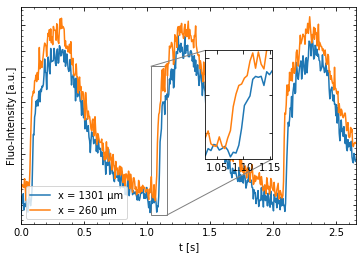

In [5]:
fig, ax = plt.subplots()
tvals = np.arange(500) * dt
ax.plot(tvals, neg_mean[:500,1000], label = "x = 1301 µm") # 1000 px /0.7687 px/µm = 1301 µm
ax.plot(tvals, neg_mean[:500,200], label = "x = 260 µm") # 200 px /0.7687 px/µm = 260 µm
ax.set_xlim(0,tvals[-1])
ax.set_ylabel('Fluo-Intensity [a.u.]')
ax.set_xlabel('t [s]')
ax.minorticks_on()
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelleft = False)

# add second axis as inset to visualize temporal shift
ax2 = plt.axes([0,0,1,1])
# manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax, [0.55,0.3,0.2,0.5])

ax2.set_axes_locator(ip)
ax2.tick_params(direction="in", right=True, top=True, labelright=False, 
                labeltop=False, labelleft =False, labelbottom=True)
mark_inset(ax, ax2, loc1=2, loc2=4, fc="none", ec='0.5')
ax2.plot(tvals,neg_mean[:500,1000])
ax2.plot(tvals,neg_mean[:500,200])
ax2.set_xlim(193*dt,217*dt)
ax2.set_ylim(116.5,131)
ax.legend(loc = 0)

fig.savefig("figs/raw_signalcomparison.pdf", dpi=300)

## extract pulse onset times tpulse(x)

In [6]:
# further averaging to reduce noise: take blockwise mean of 10 px blocks along x-axis
pos_block_mean = pos_mean[:,:1000] # take first 1000 px for even block partition
pos_block_mean = pos_block_mean.reshape(1879,100,10)
pos_block_mean = pos_block_mean.mean(axis=2) # calculate mean for each block

neg_block_mean = neg_mean[:,:1000]
neg_block_mean = neg_block_mean.reshape(1879,100,10)
neg_block_mean = neg_block_mean.mean(axis=2)

In [7]:
# help function to determine pulse onset frame (=time)
def get_tpulse(xslice, w=10):
    """ 
        extract pulse onset time defined by largest change in signal intensity
        xslice: input signal, should contain only one peak
        w: period applied for averaging of signal
    """
    mavg = np.convolve(xslice, np.ones(w), 'valid') / w
    mavg_diff = np.diff(mavg) # get slope
    t_on = np.argmax(mavg_diff) + w # find max; t is shifted by w due to moving avg
    return t_on

In [8]:
# extract pulse onset time for each position (10px averaged)
# manually select frameinterval where only one pulse occurs
xpos = np.arange(100)
tpulse = np.empty(100)

for x in xpos:
    tpulse[x] = get_tpulse(pos_block_mean[250:400,x], w=2)

## plot pulse onset times as overlay on still frame

In [9]:
# use consistent scale bar for pos and neg pulse
cbar_max=27

[[21.2896, 14], [15.9672, 18], [10.6448, 24], [5.3224, 29], [0.0, 1], [5.3224, 1], [0.0, 13]]


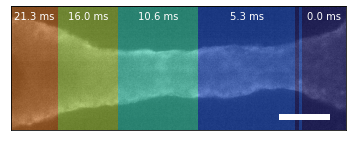

In [10]:
# final plot, extract categories from results
# https://stackoverflow.com/questions/30293071/how-can-i-find-same-values-in-a-list-and-group-together-a-new-list

tms = (tpulse - tpulse.min()) * dt * 1000 # get t in ms in relation to first pulse
# get list of connected individual pulse onset times and how often they occur
tgroups = [[i, len(list(j))] for i, j in groupby(tms)]
print(tgroups)

cmap = cm.get_cmap('jet')
ptchs = []

# create a patch element for each group consisting of 3 list entries
# xpulse: x-location, wpulse: pulse width in 10-px blocks
# tpls: time of pulse in ms in relation fo first pulse
xpulse = 0
for group in tgroups:
    tpls = group[0]
    wpulse = group[1]*10 # convert averaged blocks to image px again
    # take care, 10 px hardcoded, might change if blockwise averaging changes
    ptchs.append([xpulse,wpulse,tpls])
    xpulse += wpulse # increment by width for a correct start of the next patch

fig, ax = plt.subplots()
ax.imshow(pospulse[330,:,:1000], cmap ='gray') # plot frame 330 (arbitrary chosen) as background image
pheight = pospulse[330].shape[1]

# overlay patches on plot, patch color is chosen by pulse time
for ptch in ptchs:
    ppos, pwidth, tpls = ptch[0], ptch[1], ptch[2]
    pcol = cmap(tpls/cbar_max)
    rect = patches.Rectangle((ppos, 0), pwidth, pheight, linewidth=1, edgecolor='none', facecolor=pcol, alpha = 0.4)
    ax.add_patch(rect)
    
    if pwidth > 30: # plot timeinfo on patches which are large enough
        ax.text(ppos+pwidth/2, 30, str(round(tpls,1)) + " ms", color='white',
                horizontalalignment='center', verticalalignment='center')
        
# add scalebar
rect = patches.Rectangle((800, 320), 200*ppm, 20, linewidth=1, edgecolor='none', facecolor='white', alpha = 1)
ax.add_patch(rect)
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.savefig('figs/pospol_propagation.pdf', dpi=300, bbox_inches = 'tight',
    pad_inches = 0)

## fit linear propagation to onset times and determine contraction velocity

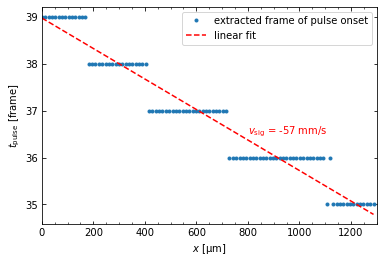

In [11]:
fig, ax = plt.subplots()

xpulse = np.arange(100)*10/ppm # convert px to µm
m,b = np.polyfit(xpulse, tpulse, 1) # linear fit
pulsefit = m * xpulse + b
velocity = 1/(m*dt) # should be µm/s

ax.plot(xpulse,tpulse, marker='.', ls='', label = 'extracted frame of pulse onset')
ax.plot(xpulse,pulsefit, marker='', ls='--', c='r', label = 'linear fit')
ax.set_ylabel("$t_{\mathrm{pulse}}$ [frame]")
ax.set_xlabel("$x$ [µm]")
ax.set_xlim(0, 1300)
ax.text(800, 36.5,"$v_{\mathrm{sig}}$ = " + str(int(velocity/1000)) + " mm/s", color = 'red')

ax.legend()
ax.minorticks_on()
ax.tick_params(direction="in", which = 'both', axis = 'both', right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(axis='y', which='minor', left=False, right = False)

fig.savefig('figs/pospol_fit.pdf',dpi=300)

## repeat for negative pulse polarity

In [12]:
xpos = np.arange(100)
neg_tpulse = np.empty(100)

for x in xpos:
    neg_tpulse[x] = get_tpulse(neg_block_mean[150:250,x], w=2)

[[0.0, 4], [5.3224, 15], [10.6448, 13], [15.9672, 27], [21.2896, 28], [26.612, 13]]


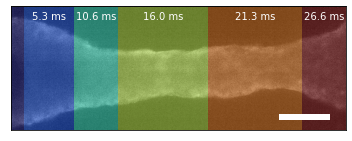

In [15]:
tms = (neg_tpulse - neg_tpulse.min()) * dt * 1000 # get t in ms in relation to first pulse
# get list of connected individual pulse onset times and how often they occur
tgroups = [[i, len(list(j))] for i, j in groupby(tms)]
print(tgroups)

cmap = cm.get_cmap('jet')
ptchs = []

# create a patch element for each group consisting of 3 list entries
# xpulse: x-location, wpulse: pulse width in 10-px blocks
# tpls: time of pulse in ms in relation fo first pulse
xpulse = 0
for group in tgroups:
    tpls = group[0]
    wpulse = group[1]*10 # convert averaged blocks to image px again
    # take care, 10 px hardcoded, might change if blockwise averaging changes
    ptchs.append([xpulse,wpulse,tpls])
    xpulse += wpulse # increment by width for a correct start of the next patch

fig, ax = plt.subplots()
ax.imshow(pospulse[330,:,:1000], cmap ='gray') # plot frame 330 (arbitrary chosen) as background image
pheight = pospulse[330].shape[1]

# overlay patches on plot, patch color is chosen by pulse time
for ptch in ptchs:
    ppos, pwidth, tpls = ptch[0], ptch[1], ptch[2]
    pcol = cmap(tpls/cbar_max)
    rect = patches.Rectangle((ppos, 0), pwidth, pheight, linewidth=1, edgecolor='none', facecolor=pcol, alpha = 0.4)
    ax.add_patch(rect)
    
    if pwidth > 60: # plot timeinfo on patches which are large enough
        ax.text(ppos+pwidth/2, 30, str(round(tpls,1)) + " ms", color='white',
                horizontalalignment='center', verticalalignment='center')
        
# add scalebar
rect = patches.Rectangle((800, 320), 200*ppm, 20, linewidth=1, edgecolor='none', facecolor='white', alpha = 1)
ax.add_patch(rect)
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.savefig('figs/negpol_propagation.pdf', dpi=300, bbox_inches = 'tight',
    pad_inches = 0)

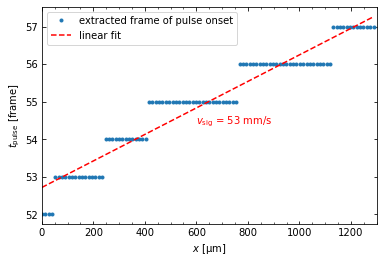

In [14]:
fig, ax = plt.subplots()

xpulse = np.arange(100)*10/ppm # convert px to µm
m,b = np.polyfit(xpulse, neg_tpulse, 1) # linear fit
pulsefit = m * xpulse + b
velocity = 1/(m*dt) # should be µm/s

ax.plot(xpulse,neg_tpulse, marker='.', ls='', label = 'extracted frame of pulse onset')
ax.plot(xpulse,pulsefit, marker='', ls='--', c='r', label = 'linear fit')
ax.set_ylabel("$t_{\mathrm{pulse}}$ [frame]")
ax.set_xlabel("$x$ [µm]")
ax.set_xlim(0, 1300)
ax.text(600, 54.4,"$v_{\mathrm{sig}}$ = " + str(int(velocity/1000)) + " mm/s", color = 'red')

ax.legend()
ax.minorticks_on()
ax.tick_params(direction="in", which = 'both', axis = 'both', right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(axis='y', which='minor', left=False, right = False)

fig.savefig('figs/negpol_fit.pdf',dpi=300)